## Installing Dependencies

In [3]:
!pip install gymnasium[box2d] stable-baselines3[extra] moviepy matplotlib

## Import + Env Setup (Gymnasium + Monitor + VecEnv)

In [4]:
import gymnasium as gym
import os
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.monitor import Monitor

# Paths
log_path = "../logs/a2c_v2_monitor.csv"

# Create raw env
def make_env():
    env = gym.make("CarRacing-v3", render_mode="rgb_array")
    env = Monitor(env, filename=log_path)
    return env

# Final wrapping order: Monitor → DummyVecEnv → FrameStack
env = DummyVecEnv([make_env])
env = VecFrameStack(env, n_stack=4)

## A2C Training Setup

In [5]:
from stable_baselines3 import A2C

model = A2C(
    policy="CnnPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./a2c_v2_tensorboard/",
    learning_rate=2.5e-4,
    n_steps=32,
    gamma=0.99,
    ent_coef=0.001,
)

model.learn(total_timesteps=300_000)
model.save("../models/a2c_driftctrl_v2")

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./a2c_v2_tensorboard/A2C_4
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -71.2    |
| time/                 |          |
|    fps                | 94       |
|    iterations         | 100      |
|    time_elapsed       | 33       |
|    total_timesteps    | 3200     |
| train/                |          |
|    entropy_loss       | -4.25    |
|    explained_variance | -0.0774  |
|    learning_rate      | 0.00025  |
|    n_updates          | 99       |
|    policy_loss        | -1.63    |
|    std                | 0.999    |
|    value_loss         | 0.199    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -67      |
| time/                 |          |
|    fps                | 90       |
|    iterations

## A2C Reward Curve

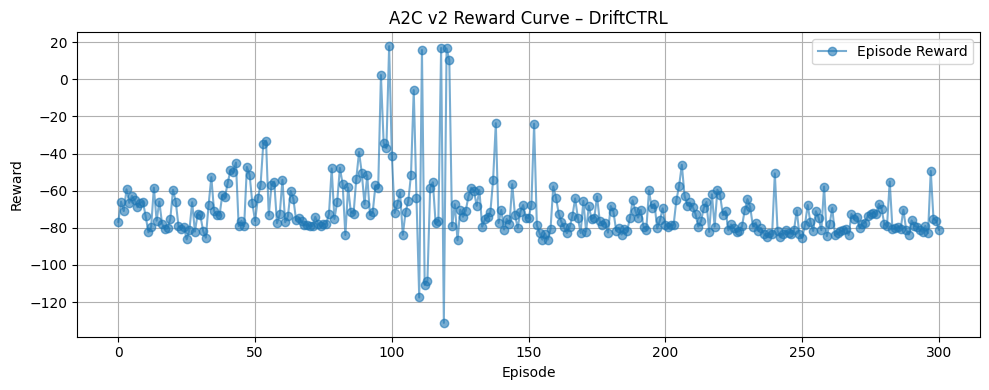

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Monitor data (must exist now!)
reward_data = pd.read_csv("../logs/a2c_v2_monitor.csv", skiprows=1)

# Plot reward per episode
plt.figure(figsize=(10, 4))
plt.plot(reward_data["r"], marker='o', linestyle='-', alpha=0.6, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("A2C v2 Reward Curve – DriftCTRL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Record MP4, Save & Record.

In [1]:
import gymnasium as gym
import imageio
import os
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

def record_video(env_id, model, video_length=2000, prefix="", output_dir="../videos", discrete=False, stack_frames=False):
    os.makedirs(output_dir, exist_ok=True)
    env = gym.make(env_id, render_mode="rgb_array")

    # Optional Discretization (for DQN)
    if discrete:
        class DiscretizeActionWrapper(gym.ActionWrapper):
            def __init__(self, env):
                super().__init__(env)
                self.discrete_actions = [
                    np.array([0.0, 0.0, 0.0]),
                    np.array([-1.0, 0.3, 0.0]),
                    np.array([1.0, 0.3, 0.0]),
                    np.array([0.0, 0.6, 0.0]),
                    np.array([0.0, 0.0, 0.5]),
                ]
                self.action_space = gym.spaces.Discrete(len(self.discrete_actions))
            def action(self, action):
                return self.discrete_actions[action]
        env = DiscretizeActionWrapper(env)

    if stack_frames:
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, n_stack=4)

    obs = env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]

    frames = []
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

        if isinstance(obs, (list, tuple)):
            obs = obs[0]
        if isinstance(done, (list, tuple)):
            done = done[0]

        frame = env.render()
        frames.append(frame)

        if done:
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]

    video_path = os.path.join(output_dir, f"{prefix}_driftctrl.mp4")
    imageio.mimsave(video_path, frames, fps=30)
    env.close()
    return video_path

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
from stable_baselines3 import A2C

model = A2C.load("../models/a2c_driftctrl_v2")

video_path = record_video(
    env_id="CarRacing-v3",
    model=model,
    video_length=2000,
    prefix="a2c_v2",
    stack_frames=True,      # required for A2C
    discrete=False           # continuous control
)

print(f"A2C v2 video saved to: {video_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A2C v2 video saved to: ../videos\a2c_v2_driftctrl.mp4


In [3]:
from IPython.display import Video
Video("../videos/a2c_v2_driftctrl.mp4", width=720)